# TP3 CSM 22/23 SV
## Docente: Gonçalo Valadão
### Elementos do grupo:
### Roman Ishchuk 43498
### Eduardo Marques 45977
### Miguel Estevinha 49779

In [1]:
import numpy as np
import scipy as sp
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
import cv2
import math
from time import time
from os import path
from PIL import Image
import re
import tabelas

### Codificação de fonte 

Este trabalho tem como objetivo implementar e analisar um condificador/descodificador JPEG sequencial para compressão de imagens a tons de cizento. A sua implementação terá como base as técnicas de compressão de codificação de fonte, isto é, tecnicas em que durante  a compressão dos dados as transformações que ocorrem nos mesmos dependem do tipo de sinal original a comprimir, ou seja, o tipo de media a  que pertence os dados a comprimir. 

As tecnicas de compressão de codificação de fonte são classificadas com três tipos distintos:

### Codificação por transformadas

A codificação por transformadas faz com os dados originais sofram uma transformação matemática a partir de um determinado domínio espacial ou temporal para um domínio mais adequado para a compressão, ou seja, para um domínio que seja mais facil identficar a informação mais significativa e descartar a informação menos significativa para não ocorra uma perda brusca dados, afetando assim a qualidade.
Como exemplos de transformações, temos a transformada de Fourier ou Fast Fourier Transform utilizada na compressão de áudio digital e as transformações mais relevantes para este trabalho, dado que estamos a comprimir imagens: A transformada discreta do Co-seno(DCT) e a transformada discreta de Hadamard(DHT). Neste trabalho usamos  a DCT, sendo esta a transformação com mais frequência na compressão JPEG. Em que os dados serão tranformados  a partir do domínio espacial para o domínio da frequência. 

### Quatificação vectorial
Neste método, o fluxo de dados será divido em blocos que são designados por vectores. Cada vector será relacionado com uma tabela de mesma dimensão do vector que contem padrões, ou seja, cada valor presente no bloco designado por vector sofrerá uma alteração com base no valor padrão de igual indice presente na tabela de padrões, com objetivo de descartar os valores menos significativos. 

### Codificação diferencial

Este método consiste em codificar a diferença entre dois valores consecutivos, ou seja, o valor atual menos o valor anteriormente codificado, dentro de uma dada sequência de valores nos  quais são diferentes de zero e não se diferenciam muito entre si. Como o resultado da diferença é menor que os valores codificados, teremos menos bits para representar a sequência de valores.


In [2]:
"""
Métodos dos trabalhos anteriores usados no tp3
"""

def write2file(seq_bit, filename):
    file = open(filename, 'wb')
    for i in range(len(seq_bit)):
        b = seq_bit[i*8:(i+1)*8]
        
        if len(b) > 0:
            nint = int(b,2)
            nbyte = nint.to_bytes (1, 'big')
            file.write(nbyte)            
            
    file.close()   

def read_file(filename):
    
    seq_bit = ""
    file = open(filename, 'rb')
    byte = ''
    while byte := file.read(1):
        nint = int.from_bytes(byte, "big") 
        b = format(nint, 'b')
        if(len(b) < 8):
            for i in range(int(8-len(b))): 
                b = '0' + b
                
        seq_bit +=b
        
    file.close()
    
    return  seq_bit 

def SNR(imgOrg, imgComp):
    #Conversão para float
    imgOrg = imgOrg * 1.0
    imgComp = imgComp * 1.0

    Psinal = np.mean(imgOrg**2)
    Perro = np.mean((imgOrg - imgComp)**2)

    return round(10*np.log10(Psinal/Perro),2)

def taxaCompressao(imgOrg, imgComp):
        return np.round(imgOrg/imgComp)

def percentagemReducao(imgOrg, imgComp):
        
        return round(100 - (imgComp * 100)/imgOrg, 2)

#### Blocos 8x8
Para que se possa dividir os dados da imagem em blocos de 64 pixels, foi criada a função blocos8x8(image), função que recebe uma imagem e devolve uma list de blocos, cada um com dimensão de 64 pixels.
Para para juntar os blocos e formar novamente a imagem, foi criada a função blocks_to_image(blocks), função que recebe uma lista de blocos e retorna os dados da imagem, ou seja, os blocos organizados conforme a imagem original.

In [19]:
def blocos8x8(image):
    c, l = image.shape
    blocos = []

    for x in range(0, c, 8):
        for y in range(0, l, 8):
            blocos.append(image[x:x+8, y:y+8])
        
    return blocos

def blocks_to_image(blocks):
   
    num_blocks_h, num_blocks_w = blocks.shape[1]*8, blocks.shape[2]*8
    h, w = num_blocks_h * 8, num_blocks_w * 8
    
    # 3D para 2D
    reshaped_blocks = blocks.reshape(num_blocks_h, num_blocks_w, 8, 8)
    #print(reshaped_blocks.shape)
    
    # Transposta e reshape para ter o aspeto de imagem
    transposed_blocks = reshaped_blocks.transpose(0, 2, 1, 3)
    #print(transposed_blocks.shape)
    img_data = transposed_blocks.reshape(h, w)
    #print(img_data.shape)
    
    return img_data

#### 1. DCT e IDCT


##### DCT
Como referido na introdução, para a compressão jpeg usámos a transformada DCT, que será aplicada a cada bloco de 64 pixeis 
que constituem a imagem original, sofrendo assim uma transformação matemática que passa do domínio espacial para o domínio das frequências. Tendo como resultado para cada bloco coefecientes ou amplitudes das 64 cossenoides de frequências destintas que ao serem somadas formam o bloco de pixels da imagem original.

Para a implementação desta transformada, foi feita a função codificador_DCT(filename), função esta que recebe como argumento o caminho para a imagem a ser codificada e retorne os coefecientes das 64 cossenoides de cada bloco que constitui a imagem original.

A função recebe os dados da imagem através do caminho passado pelo parâmetro e converte o espaço de cores da imagem de rgb para grayscale. Depois divide os dados da imagem em blocos de 64 píxeis, em seguida foi aplicada a transformada dct em cada bloco e os coefecientes resultantes são guardados numa lista(blocos_cod), e no final é retornado a lista de blocos transformados.

Os coefecientes ou amplitudes podem ser interpretados como pesos, isto é, a significância de cada cossenoide em cada bloco, que quando somadas formam a imagem 8x8 que representa o bloco constituinte da imagem.

##### IDCT
Esta transformação também é inversível ao ser aplicada a transformada inversa, cujo o resultado são os dados da imagem original.

Para a implementação da transformada inversa foi feita a função descodificador_DCT, função que recebe  os blocos transformados(DCT) e um nome de ficheiro. Depois, aplica-se a transformada inversa em cada um desses blocos para obter os valores originais da imagem. Se for dado um nome de ficheiro, é aplicada a função anteriormente descrita blocks_to_image(blocks) ao blocos idct para que se possa formar os dados originais da imagem e em seguida guardar os mesmo em um ficheiro com o nome de ficheiro dado como parâmetro. Se não houver um nome de ficheiro, então a função retorna os blocos idct.

In [17]:
def codificador_DCT(filename):

    lena = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    lena = np.array(lena)#, dtype=np.float64)
    
    blocos = blocos8x8(lena)
    
    blocos_cod = []

    for bloco in blocos:
        bloco = np.array(bloco)
        bloco - 128
        bloco.tolist()
        blocos_cod.append(dct(dct(bloco.T, norm = 'ortho').T, norm = 'ortho'))    
    
    return blocos_cod

def descodificador_DCT(blocos_cod, filename = None):
  
    blocos_cod = np.array(blocos_cod)
    blocos_descod = []

    for bloco in blocos_cod:
        bloco_aux = idct(idct(bloco.T, norm='ortho').T, norm='ortho')
        bloco = np.array(bloco_aux)
        bloco + 128
        bloco.tolist()
        blocos_descod.append(bloco)

    if filename:
        blocos_descod = np.array(blocos_descod)
        img_data = blocks_to_image(blocos_descod)

        img_data = np.array(img_data)
        img = Image.fromarray(img_data)
        img = img.convert("L")
        img.save(filename)
    
    else:
        return blocos_descod
    

(64, 64, 8, 8)
(64, 8, 64, 8)
(512, 512)
(64, 64, 8, 8)
(64, 8, 64, 8)
(512, 512)


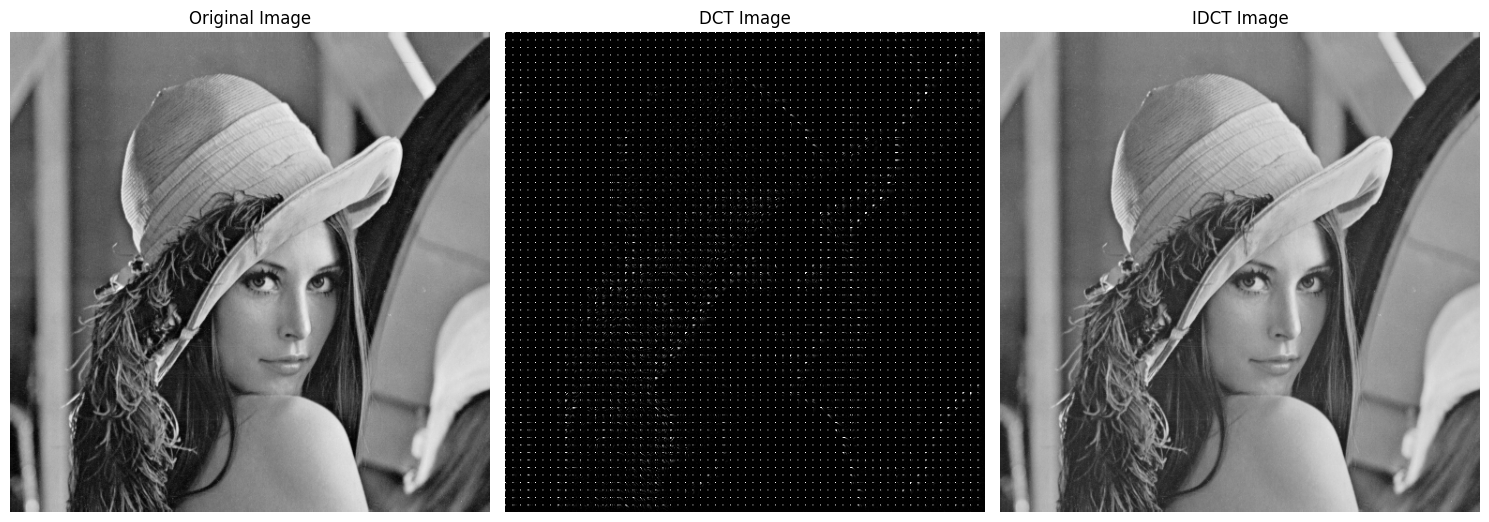

In [18]:
blocos_DCT  = codificador_DCT('LenaGray.tif')
blocos_IDCT = descodificador_DCT(blocos_DCT)
#OriginalImage
lena = cv2.imread('LenaGray.tif', cv2.IMREAD_GRAYSCALE)


#DCT_Image
blocos_DCT = np.array(blocos_DCT)
img_data = blocks_to_image(blocos_DCT)
img_data = np.array(img_data)
img_dct= Image.fromarray(img_data)


#IDCT_Image
blocos_IDCT = np.array(blocos_IDCT)
img_data = blocks_to_image(blocos_IDCT)
img_data = np.array(img_data)
img_idct = Image.fromarray(img_data)


plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(lena, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_dct, cmap='gray')
plt.title('DCT Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_idct, cmap='gray')
plt.title('IDCT Image')
plt.axis('off')

plt.tight_layout()
plt.show()



#### 2. Quantificação

##### Quantificação
Após a aplicação DCT em que os blocos de píxeis que constituem a imagem transformam-se em um conjunto de coefecientes DCT, 
é aplicada a quantificação, que elimina os coefecientes menos significativos de cada bloco de pixeis. Transformando,assim, este processo em um processo de compressão com perdas.

Para a implementação da quantificação foi feita a função quantificação() que recebe como parâmetros os blocos transformados e o fator de qualidade e retorna os blocos quantificados.

Ao receber os blocos transformados, divide-se cada bloco por uma matriz de quantificação padrão, Q, multiplicada pelo factor de qualidade dado nos parâmetros, de seguida é arredondado ás unidades cada bloco quantificado, assim eliminando os coeficientes menos significativos. E no final retorna os blocos quantificados.


##### Desquantificação

Apesar da quantificação ser reversível, não é possível recuperar os dados perdidos na quantificação.

Para a implementação da quantificação foi feita a função desta desquantificacao() que recebe como argumentos os blocos quantificados e o fator de qualidade e retorna os blocos de coefecientes DCT.

Ao receber os blocos quantificados, cada bloco é multiplicado pela matriz de quantificação, Q, usada na quantificação, multiplicada pelo factor de qualidade dado como parâmetro. Retornando os blocos de coefecientes DCT.

In [6]:
def quantificacao(blocos, qualidade):
    blocos_quant = []
    
    #print(blocos.shape)

    for bloco in blocos:
        bloco_q = (bloco/(np.array(tabelas.Q)*tabelas.quality_factor(qualidade)))
        bloco_q = np.where(np.logical_and(bloco_q >= -1, bloco_q <= 1), 0, bloco_q)
        bloco_q = np.round(bloco_q)
        blocos_quant.append(bloco_q)
    #return np.array(blocos_quant)
    blocos_quant = np.array(blocos_quant)
    #print(blocos_quant.shape)
    #image = blocks_to_image(np.array(blocos_quant))
    #img = Image.fromarray(image)
    #img = img.convert("L")
    #img.save("LenaGrayQuant.jpeg")

    return np.array(blocos_quant)
    
def desquantificacao(blocos_quant, qualidade):
    blocos_dequant = []
    
    for bloco in blocos_quant:
        blocos_dequant.append((bloco*(np.array(tabelas.Q)/tabelas.quality_factor(qualidade))))
        #blocos_dequant.append(np.dot(bloco/quality_factor(1), np.array(Q)))
    
    image = blocks_to_image(np.array(blocos_dequant))
    img = Image.fromarray(image)
    img = img.convert("L")
    img.save("LenaGrayDesquant.jpeg")

    return np.array(blocos_dequant)

#### 3. Valores DC

Após a quantificação dos coefecientes dct, feita uma codificação preditiva aos valores DC e AC de cada bloco da imagem, sendo o valor Dc o primeiro valor de cada bloco, isto é, o valor de índice [0,0], que corresponde á energia total do bloco.

Para a codificação dos valores DC, utilizou-se a codificação diferencial(DPCM),  que consiste em codificar a diferença entre o valor DC do bloco atual e o valor DC do bloco anteriormente codificado, para que assim se possa representar a sequência de valores com menos bits. 

##### Valores DC
Para a implementação da codificação dos valores DC, foi feita a função valores_DC(), que recebe com argumentos os blocos quantificados e retorna os valores DC codificados.

Ao receber os blocos quantificados, é indexado em uma lista a amplitude correspodente á diferença entre o valor DC atual e o valor DC anterior, de seguida é retornada essa lista.

##### Desvalores DC

Para obter novamente os valores quantificados, foi feita a função desvaloresDC(), que recebe os valores DC codificados e retorna os  valores quantificados.

Ao receber os valores DC codificados  é somado as diferenças entre a do bloco atual a ser descodificado e a do bloco anterior,originando os valores DC quantificados,de seguida o resultado é indexado em uma lista e, por fim é retornada a mesma.


In [7]:
def valores_DC(blocos_quant):  
    encoded_dc = []
    prev_dc = 0

    for i in range(blocos_quant.shape[0]):
        dc = blocos_quant[i, 0, 0]
        encoded_dc.append(int(dc - prev_dc))
        prev_dc = dc

    return encoded_dc

def desvalores_DC(encoded_dc):   
    decoded_dc = []
    prev_dc = 0
    
    for i in range(len(encoded_dc)):
        dc = encoded_dc[i] + prev_dc
        decoded_dc.append(int(dc))
        prev_dc = dc
    return decoded_dc

#### 4. Valores AC

Para o processamento dos valores AC, não se utiliza a ordem convencional(da esquerda para direita, de cima para baixo), mas sim processados por uma ordenação ziguezague.
É utilizada esta ordenação, pois garante que será processado primeiro os coefecientes não nulos, que corrrespondem ás frequências mais baixas do bloco, deixado no final os coefecientes nulos.

##### Valores AC
Para a implementação da codificação dos coefecientes AC, foi feita a função valores_AC(), que recebe como parâmetro os blocos quantificados e retorna os valores AC codificados.

Primeiro, foi feita uma lista com os indices dos valores AC a serem codificados de acordo com a ordem ziguezague, de seguida, em cada bloco, é feita a codificação RL, que obtém o valor AC não-nulo e calcula o número de valores AC nulos precedentes do coefecientes não-nulo atual, formando um par de parâmetros(run, amplitude). O número de coefecientes nulos que precedem o valor não nulo atual pode ser maior do que 15, neste caso usa-se o par(15/0) de 15 zeros e tamanho 0. 
Quando todos os coefecientes não nulos são codificados, os restantes coefecientes nulos são representados por pelo par (0/0) que representa o fim do bloco. 

No final é retornado uma lista com os pares anteriormente processados.

##### Desvalores AC

Para obter os valores novamente dos coefecientes AC, processo é semelhante. Cria-se um 2D array de zeros que representa um bloco 8x8 píxeis para facilitar a descodificação dos valores nulos, de seguida uma lista com os indices dos valores AC a serem codificados de acordo com a ordem ziguezague, posteriormente é posicionado os valores AC no array de zeros de acordo com o primeiro parâmetro do par(run, amplitude). Quando chegar ao par (0,0) singifica que já foram descoficados todos os valores não nulos e que está completo o bloco com os valores AC quantificados.

E no final é returnado uma lista dos blocos de valores AC.

In [8]:
def valores_AC(blocos_quant):

    zzD = []
    AC = []
    count = 0
    flag = 0

    for i in range(64):
        indice = np.argwhere(tabelas.zigzag == i)
        indice = indice.tolist()
        zzD.append(indice[0])
    
    #print(zzD)

    for bloco in blocos_quant:
        zeros = 0

        for idx in zzD:
            count +=1
            if(idx == [0,0]):#O valor de índice [0,0] é um coefeciente DC
                continue
            else:
                if(bloco[idx[0]][idx[1]] == 0):
                    zeros += 1
                    if(zeros >= 15):
                        AC.append((15,0))
                        flag +=1
                        zeros = -1
                else:
                    if zeros < 0:
                        zeros = 0
                    AC.append((zeros, round(bloco[idx[0]][idx[1]])))
                    flag = 0
                    zeros = 0
                #print(AC)
        if(flag > 0):
            AC = AC[:-flag]
        AC.append((0,0))
        flag = 0 
    return AC

def desvalores_AC(ac):
    zzD = []
    array = np.zeros((8,8))
    blocos = []
    zeros = 0
    for i in range(64):
        indice = np.argwhere(tabelas.zigzag == i)
        indice = indice.tolist()
        zzD.append(indice[0])

    #for bloco in ac:
    for idx in ac:
        if(idx[1] == 0 and idx[0] != 0):
            zeros += idx[0] + 1
        elif(idx[1] == 0 and idx[0] == 0):
            blocos.append(array)
            array = np.zeros((8,8))
            zeros = 0
        else:
            zeros += idx[0] + 1
            array[zzD[zeros][0]][zzD[zeros][1]] = idx[1]
    
    return blocos


#### 5. juntarDCAC()
Esta função recebe como parâmetro os valores AC e DC codificado e retorna os blocos com os valores AC e DC.

In [9]:
def juntarDCAC(dc, ac):
    blocos = []
    aux = 0
    for bloco in ac:
        bloco[0][0] = dc[aux]
        blocos.append(bloco)
        aux += 1
    return blocos

#### Converter()
Recebe como parâmetro um valor em binário e retorna a representação em complemento para um desse valor.

#### div_AC()
Este método recebe uma lista de acs recebida em sub listas, listas essas que são divididas quando é encontrado o valor (0,0), ou seja, quando é entrado o final doa valores AC do bloco em questão. Esta divisão é útil para ser feita uma codificação mais direta, pois iremos codificar o valor Dc do bloco x e os valores Ac do mesmo bloco, sem ser necessário haver, a cada iteração, uma verificação se estavamos presente o valor (0,0).

#### undiv_AC()
É feito o contrário do div_AC para que sejam depois seja efectuado o contrário do cálculo dos vals AC.

In [10]:
def converter(code):
    icode = ""
    for c in code:
        icode += str(1-int(c))
    return icode

def div_AC(acs):
    blocos_ac = []
    idc = 0
    for i in range(len(acs)):
        #fim de bloco
        if(acs[i] == (0,0)):
            new_bloco = []
            while(idc<i+1):
                new_bloco.append(acs[idc])
                idc+=1
            blocos_ac.append(new_bloco)

    return blocos_ac

def undiv_AC(acs):
    lista_AC = []

    for bloco in acs:
        for idx in bloco:

            lista_AC.append(tuple(idx))

    return lista_AC

#### 6.Code 

Após a codificação preditiva(DPCM e RLC), utilizamos a codificação de Huff-man.

##### code_DCAC()

Para a implementação da codificação de Huffman, foi feita a função code_DCAC() que recebe como parâmetros o factor de qualidade e os pares de valores de AC e DC e retorna uma sequência de bits que  representa a mensagem codificada.

Primeiro, codifica-se os coefecientes DC, obtendo os valores das diferenças e o seu tamanho em bits. Após obter este par de parâmetros (size, amplitude) codifica-se o primeiro elemento(size) com uma tabela huffman(K3), utilizando como índice o primeiro valor do par(size), e para a codificação da amplitude, converte-se directamente o valor para binário se o mesmo for positivo, mas se for negativo, é feito o complementar para 1 da representação binária do valor positivo com funçao anteriormente descrita converter().
Após a codificação do coefecientes DC, foi feita a codificação dos valores AC de a cada bloco. Ao obter o valor AC e o seu valor run, é calculado o tamanho em bits do mesmo, formando assim o par (run/size, amplitude) em que o primeiro elemento, constituido por 2 valores é usado como índice para uma tabela de huffman(K5) que codifica esse primeiro elemento. Para a codificação da amplitude, é utilizado o mesmo processo acima descrito na codificação dos valores DC.

Retornando, assim, a sequência de bits correspondeste aos blocos codificados.


##### decode_DCAC()

Para a descodificação, foi feita a função decode_DCAC() que recebe como parâmetro a sequência de bits correspondente aos dados codificados e retorna blocos com os pares de valores correspondentes ao valores DC e AC.

Primeiro, descodificou-se os valores DC. Da sequência de bits obtém-se os bits correspondentes ao primeiro elemento do par que representa o valor DC, size, para que assim se possa obter o valor original do tamanho em bits da amplitude, sendo que este valor foi usado como índice para obter os bits de codificação da tabela K3. Para obter o valor da amplitude, verifica--se a sequência de bits correspondentes á mesma começa com 0, se for caso, é feito o complementar para um na sequência de bits, de seguida é convertida para inteiro, se começar com 1, é feita a conversão diretamente para inteiro.

Após a descodificação do coefecientes DC, foi feita a descodificação dos valores AC. Tal como o DC, obtém-se os bits correspondentes ao primeiro elemento do par que representa o valor AC, para obter  o valor de run e os valor do tamanho em bits da amplitude, utilizando a tabela K5 usada anteriormente na codificação. Para obter o valor da amplitude usou-se o mesmo método da descodificação DC.

In [11]:
def code_DCAC(qualidade, dc, ac): 

    blocosAC = div_AC(ac)

    code = ""
    code += bin(qualidade)[2:].zfill(7)
    b = 0
    for valDc in dc:

        #
        #Cod da componente DC de cada bloco
        #
        if valDc == 0:
            code += tabelas.K3[0]
        
        else:
            val = valDc
            code_aux = ""

        
            if val < 0:
                #3: porque aparece -0b(cod bin)
                code_aux += converter(bin(val)[3:])
            else:
                #2: porque aparece 0b(cod bin)
                code_aux = bin(val)[2:]
        
            code += tabelas.K3[len(code_aux)]
            code += code_aux
        
        #
        #Cod das componentes AC de cada bloco
        #
        for i in range(len(blocosAC[b])):
            bloco = blocosAC[b][i]
            n_zeros = bloco[0]
            prox_val = bloco[1]

            if n_zeros == 0 and prox_val == 0:
                prox_size = 0
                code += tabelas.K5[(n_zeros, prox_size)]

            else:
                if prox_val < 0:
                    prox_val_bin = converter(bin(prox_val)[3:])       
                    prox_size = len(prox_val_bin) 
                    
                else:
                    prox_val_bin = bin(prox_val)[2:]
                    prox_size = len(prox_val_bin)
                    
                if prox_val == 0:
                    prox_size = 0

                #print("zeros: ", n_zeros)
                #print("prox_size: ", prox_size)

                code += tabelas.K5[(n_zeros, prox_size)]
                if prox_val != 0:
                    code += prox_val_bin
        b += 1

    "stuffing"

    num_stuff = 8 - ((len(code) + 3)%8)

    if num_stuff == 8:
        num_stuff = 0
    
    num_stuff_b = bin(num_stuff)[2:].zfill(3)
    stuff_b = '0' * num_stuff
    code = num_stuff_b + code + stuff_b    

    return code


def decode_DCAC(msg_cod):

    #número de bits de stuffing
    num_stuff = int(msg_cod[:3], 2)
    if num_stuff > 0:
        #retirar os bits de stuffing do final da msg
        msg_noStuffing = msg_cod[3:-num_stuff]
    else:
        msg_noStuffing = msg_cod[3:]

    qualidade = int(msg_noStuffing[:7], 2)
    #print(qualidade)
    code = msg_noStuffing[7:]

    dc = []
    ac = []
    lista_vals_k3 = list(tabelas.K3.values())
    lista_keys_k3 = list(tabelas.K3.keys())
    lista_vals_k5 = list(tabelas.K5.values())
    lista_keys_k5 = list(tabelas.K5.keys())
    #print(lista_vals_k3)
    #print(lista_keys_k5)
    #lista_keys

    #print(code)

    
    while len(code) > 0:
        seqDC = ""
        seqAC = ""
        AC_aux = []
        aux = 0
        dc_encontrado = False
        ac_fim = False
        
        while not dc_encontrado:
            #print(code[aux])
            
            seqDC += code[aux]
            aux += 1

            if seqDC in lista_vals_k3:
                dc_encontrado = True
                #Tiramos os bits encontrados
                code = code[aux:]
                n_bits_DC = lista_keys_k3[lista_vals_k3.index(seqDC)]
                
                #Obtemos os bits do valor da DC e retiramos da palavra de código
                val_bin_DC = code[:n_bits_DC]
                code = code[n_bits_DC:]

                if n_bits_DC == 0:
                    val_DC = 0
                
                else:
                    if val_bin_DC[0] == "0":
                        val_DC = -int(converter(val_bin_DC),2)
                    else:
                        val_DC = int(val_bin_DC, 2)

                dc.append(val_DC)
                #print(len(dc))
        aux = 0
        #print(code)
        while not ac_fim:
            #print(len(AC_aux))
            seqAC += code[aux]
            aux += 1

            if seqAC in lista_vals_k5:
                #print(seqAC)
                #Tiramos os bits encontrados
                code = code[aux:]
                #print("codigo antes de retirar vals", code)

                if(seqAC == "1010"):
                    ac_fim = True
                    AC_aux.append([0,0])
                    ac.append(AC_aux)
                    #print(code)
                    
                else:
                    vals_AC = lista_keys_k5[lista_vals_k5.index(seqAC)]
                    n_zeros = vals_AC[0]
                    size = vals_AC[1]
          
                    if size != 0:
                        #print("valor seguinte: ", val_seguinte)

                        #bits_val_seguinte = len(bin(size)[2:])
                        #print("número de bits: ", bits_val_seguinte)

                        val_b = code[:size]
                        #print(val_b)
                        #print("bits do proximo valor: ", val_b)
                        
                        code = code[size:]
                        #print(code)

                        if val_b[0] == "0":
                            AC_aux.append([n_zeros, -int(converter(val_b), 2)])
                        else:
                            AC_aux.append([n_zeros, int(val_b, 2)])

                    else:
                        AC_aux.append([n_zeros, size])                        

                seqAC = ""
                aux = 0
                #print("Codigo depois de retirar: ", code)
                
    return qualidade, dc, ac

In [12]:
#Teste

E    = np.zeros((8,8))
E[0] = [-240, 4, 3, -1, 2, 5, -4, 5]
E[1] = [1, 2, -1, 2, -2, 3, -1, 2]
E[2] = [3, 4, -3, 5, 6, 3, 2, 2]
E[3] = [-1, -1, 2, -58, 4, 5, 4, 2]
E[4] = [1, -25, 3, 4, -1, 2, 2, 1]
E[5] = [3, 2, -5, 4, -3, 2, 1, 1]
E[6] = [2, -1, 3, 2, 2, -1, 2, 1]
E[7] = [1, -1, 1, 2, -3, 4, 1, 1]

qualidade = 50

blocosE = np.array([E])
bloco_q = quantificacao(blocosE, qualidade)
print(bloco_q)

Dc = valores_DC(bloco_q)

Ac = valores_AC(bloco_q)
#print(Ac)

codeDCAC = code_DCAC(qualidade, Dc, Ac)
#print(codeDCAC)
#print(codeDCAC)
qual, dc, ac = decode_DCAC(codeDCAC)

ac = undiv_AC(ac)


bloco_desvalorAC = desvalores_AC(ac)
#print(bloco_desvalorAC)

bloco_desvalorDC = desvalores_DC(dc)
#print(bloco_desvalorDC)

bloco_inteiro = juntarDCAC(bloco_desvalorDC, bloco_desvalorAC)
print()
print(np.array(bloco_inteiro))

[[[-15.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.  -2.   0.   0.   0.   0.]
  [  0.  -1.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.]]]

[[[-15.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.  -2.   0.   0.   0.   0.]
  [  0.  -1.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.]]]


In [13]:
file_orig = "LenaGray.tif"
size_orig = path.getsize(file_orig)

qualidades = [10, 20, 30, 50]

TC_alunos = []
SNR_alunos = []

for qualidade in qualidades:
    print(str(qualidade))
    print()

    file_bin = "LenaGrayComp" + str(qualidade) + ".bin"
    file_jpg = "LenaGrayDCTIDCT" + str(qualidade) + ".jpeg"

    #Compressão para bin
    t0 = time()
    blocos_cod = codificador_DCT(file_orig)

    blocos_quant = quantificacao(blocos_cod, qualidade)
    #print(blocos_quant)

    encoded_dc = valores_DC(blocos_quant)

    encoded_ac = valores_AC(blocos_quant)

    codeDCAC = code_DCAC(qualidade, encoded_dc, encoded_ac)

    tempo = time() - t0
    print("Tempo de compressão: ", tempo)
    print()

    write2file(codeDCAC, file_bin)

    #Descompressão do bin

    t1 = time()

    code_to_decode = read_file(file_bin)

    qual, dc, ac = decode_DCAC(code_to_decode)

    ac = undiv_AC(ac)

    decided_dc = desvalores_DC(dc)
    #print(decided_dc)
    decided_ac = desvalores_AC(ac)

    bloco_inteiro = juntarDCAC(decided_dc, decided_ac)


    blocos_desquant = desquantificacao(bloco_inteiro, qual)
    descodificador_DCT(blocos_desquant, file_jpg)

    tempo = time() - t1
    print("Tempo de descompressão e escrita: ", tempo)
    print()

    size_jgp = path.getsize(file_jpg)

    SNR_val = SNR(size_orig, size_jgp)
    SNR_alunos.append(SNR_val)
    taxa_comp = taxaCompressao(size_orig, size_jgp)
    TC_alunos.append(taxa_comp)
    percet_redu = percentagemReducao(size_orig, size_jgp)

    print("Valor da SNR da imagem com valor " + str(qual), "de qualidade: " + str(SNR_val) + "dB")
    print("Taxa de compressão da imagem com valor " + str(qual) + "de qualidade: 1/" + str(taxa_comp))
    print("Percentagem de redução da imagem com valor " + str(qual) + "de qualidade: " + str(percet_redu) + "%")
    print()

10

Tempo de compressão:  0.5219211578369141

Tempo de descompressão e escrita:  0.26322102546691895

Valor da SNR da imagem com valor 10 de qualidade: 0.21dB
Taxa de compressão da imagem com valor 10de qualidade: 1/42.0
Percentagem de redução da imagem com valor 10de qualidade: 97.63%

20

Tempo de compressão:  0.513355016708374

Tempo de descompressão e escrita:  0.3127138614654541

Valor da SNR da imagem com valor 20 de qualidade: 0.38dB
Taxa de compressão da imagem com valor 20de qualidade: 1/24.0
Percentagem de redução da imagem com valor 20de qualidade: 95.75%

30

Tempo de compressão:  0.5453999042510986

Tempo de descompressão e escrita:  0.48534607887268066

Valor da SNR da imagem com valor 30 de qualidade: 0.53dB
Taxa de compressão da imagem com valor 30de qualidade: 1/17.0
Percentagem de redução da imagem com valor 30de qualidade: 94.1%

50

Tempo de compressão:  0.5584061145782471

Tempo de descompressão e escrita:  0.6998100280761719

Valor da SNR da imagem com valor 50 de

In [14]:
file_orig = "LenaGray.tif"
size_orig = path.getsize(file_orig)

qualidades = [10, 20, 30, 50]

TC_cv2 = []
SNR_cv2 = []

for qualidade in qualidades:

    lenaCV2 = "lenaCV2" + str(qualidade) +" .jpg"
    cv2.imwrite(lenaCV2, lena, (cv2.IMWRITE_JPEG_QUALITY, qualidade))

    cv2.imread(lenaCV2)

    size_jgp = path.getsize(lenaCV2)
        
    SNR_cv2.append(SNR(size_orig, size_jgp))
    TC_cv2.append(taxaCompressao(size_orig, size_jgp))

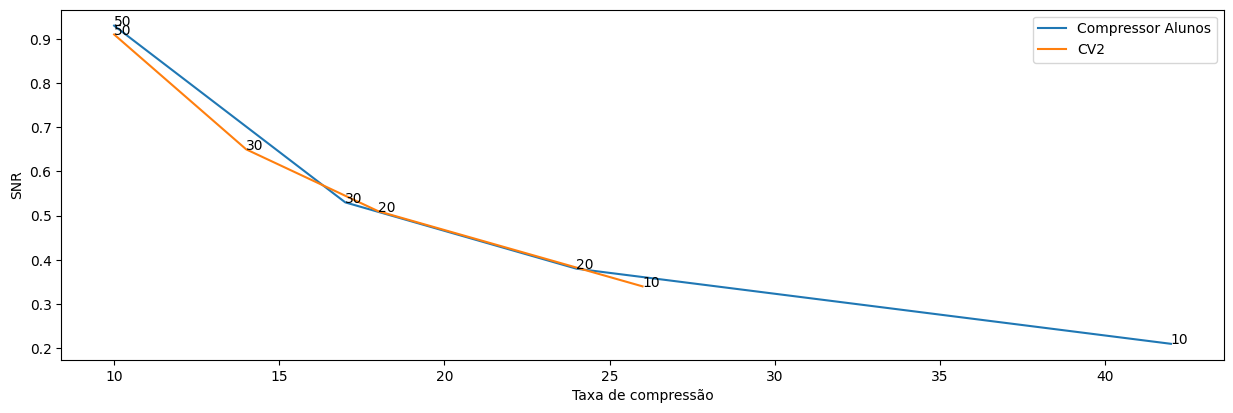

In [20]:
qualidades = [10, 20, 30, 50]
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(TC_alunos[:], SNR_alunos[:], label="Compressor Alunos")
plt.plot(TC_cv2[:], SNR_cv2[:], label="CV2")
plt.legend()
plt.xlabel("Taxa de compressão")
plt.ylabel("SNR")
for i in range(len(qualidades)):
    plt.annotate(str(qualidades[i]), xy=(TC_alunos[i], SNR_alunos[i]))
    plt.annotate(str(qualidades[i]), xy=(TC_cv2[i], SNR_cv2[i]))
#for i in range(len(qualidades)):
    #plt.annotate(str(qualidades[i]), xy=(TC_cv2[i], SNR_cv2[i]))

Ao compararmos os valores do compressor produzido pelo grupo e o compressor da biblioteca OpenCV2, podemos afirmar que para valores mais altos, como a qualidade 50, o compressor feito pelo grupo tem uma taxa de compressão parecida à biblioteca, porém, à medida que os valores de compressão vão diminuindo, podemos afirmar que a compressão feita pelo grupo é mais comprimida do que a compressão da biblioteca. Esta discrepância de valores de compressão pode estar associado ao erro que o grupo não conseguiu resolver no codificador_dct, mesmo tendo o grupo feito a implementação da maneira sugerida pelo professor.